In [1]:
import os 
from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA_DIR = '/pool001/jschless/kiran-data/kiran-data/'
TURKEY_DIR = '/pool001/jschless/turkish_astroturfing'

In [2]:
# Loading df created in the Turkey_Data_Wrangling notebook
df = pd.read_pickle(os.path.join(DATA_DIR, 'mega_df_full_follower_final.pkl')).drop_duplicates(subset=['id'])
df.head()

,created_at,favorite_count,id,text,n_followers,n_friends,n_statuses,author,author_id,trend,...,tr_start,tr_end,vol,max_rank,lifetime,attack,time_trending,time_since_trending,lexicon,follower_data
0,2020-05-02 14:05:16,1.0,1256585550796148738,#MilliGazeteOkuyorum #SesimizBir #Cumartesi #D...,1767.0,2161.0,142612.0,GunesliGuzel,293656352,#ÜniversiteliİşçilereAdalet,...,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,00:40:04,434672,False,True
4,2019-11-18 17:38:31,10.0,1196482833696645120,Kamuda çalışan üniversiteli işçiler memur stat...,809.0,2573.0,10232.0,yaprakergen,325766266,#ÜniversiteliİşçilereAdalet,...,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,00:40:04,195845,False,False
8,2019-11-11 17:02:57,NaN,1193937167007068160,@MemurSenKonf Üniversite mezunu 4D'li işçiler ...,1245.0,1310.0,1624.0,Erdemakkusss,965200054352076800,#ÜniversiteliİşçilereAdalet,...,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,00:40:04,185730,False,True
12,2019-11-11 15:21:30,NaN,1193911634013630466,@_aliyalcin_ Üniversite mezunu 4D'li işçiler o...,1245.0,1310.0,1624.0,Erdemakkusss,965200054352076800,#ÜniversiteliİşçilereAdalet,...,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,00:40:04,185628,False,True
16,2019-11-11 15:21:17,NaN,1193911580230062080,@SabahMemurlar Üniversite mezunu 4D'li işçiler...,1245.0,1310.0,1624.0,Erdemakkusss,965200054352076800,#ÜniversiteliİşçilereAdalet,...,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,00:40:04,185628,False,True


# Build Network

In [3]:
def get_friends(filename):
    return (
        pd.read_csv(os.path.join(DATA_DIR, filename),  # loading data
                    sep='\t', names=['user', 'friend'])
        .groupby('user') # group by the user 
        .apply(lambda x: set(x.friend)) # get set of all friends
        .to_dict() # convert it to a python dictionary
    )
friends_dict = {**get_friends('FRIENDS.txt'), **get_friends('FRIENDS1.txt')}

KeyboardInterrupt: 

In [6]:
users = df.query('follower_data == True').author.unique().tolist()
users_dict = {v: i for i,v in enumerate(users)}

In [ ]:
# 300k users
edge_list = []
for i, name in tqdm(enumerate(users)):
    friends = friends_dict.get(name, set())
    for f in friends:
        friend_ind = users_dict.get(f, -1)
        if friend_ind != -1:
            edge_list.append((i, friend_ind))

In [ ]:
import graph_tool.all as gt
g = gt.Graph()
g.add_edge_list(edge_list)
# g.save(os.path.join(DATA_DIR, 'follower_network.gt'))
g

In [4]:
import graph_tool.all as gt
g = gt.load_graph(os.path.join(DATA_DIR, 'follower_network.gt'))
g

<Graph object, directed, with 333284 vertices and 64146528 edges, at 0x2aabda24ddc0>

### Creating a followers dict from the graph
For exposure calculations, we want to know who in the network is following a given user.
This is equivalent to the source vertices of the in-edges for each vertex 

In [7]:
followers_dict_i = {i: g.get_in_neighbors(i) for i in range(len(users))}

In [8]:
followers_dict = {users[i]: [users[x] for x in neighbors] for i,neighbors in followers_dict_i.items()}

In [37]:
import pickle
with open(os.path.join(DATA_DIR, 'followers_dict.pkl'), 'wb') as f:
    pickle.dump(followers_dict, f)

## Generate Statistics
- in-degree
- out-degree
- num friends
- category
- num tweets
- num retweets
- num newly exposed

In [9]:
def network_statistics(g):
    out_degrees = g.get_out_degrees(g.get_vertices())
    in_degrees = g.get_in_degrees(g.get_vertices())
    
    return pd.DataFrame({'in_degree': in_degrees, 'out_degree': out_degrees}, 
                 index=users)

In [10]:
def df_statistics(df):
    unique_authors = df.drop_duplicates(subset=['author']).set_index('author')

    user_info = unique_authors[['n_followers', 'n_friends', 'n_statuses']]
    
    grouped = df.groupby('author')
    temp = df.groupby('author').sum()
    total_favorites = temp.favorite_count
    newly_exposed = temp.n_newly_exposed
    n_tweets = grouped.count().id
    n_trends = grouped.apply(lambda x: len(x.trend.unique()))
    

    user_info['total_favorites'] = total_favorites
    user_info['n_newly_exposed'] = newly_exposed
    user_info['n_tweets'] = n_tweets
    user_info['n_trends'] = n_trends
    
    return user_info
    

In [11]:
%%time 
user_info = df_statistics(df)

<ipython-input-10-f526d84abdee>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_info['total_favorites'] = total_favorites
<ipython-input-10-f526d84abdee>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_info['n_newly_exposed'] = newly_exposed
<ipython-input-10-f526d84abdee>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

CPU times: user 1min 1s, sys: 942 ms, total: 1min 2s
Wall time: 1min 2s


<ipython-input-10-f526d84abdee>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_info['n_trends'] = n_trends


In [12]:
network_info = network_statistics(g)

In [13]:
user_df = user_info.join(network_info)

In [14]:
%%time 
def label_user(df):
    # should assign a label to a user based on _
    # - posted lexicon
    # - unexposed
    # - exposed
    df = df.sort_values('created_at')
    if any(df.lexicon):
        return "astrobot"
    elif all(df.exposed):
        return "exposed" 
    else:
        return "unexposed"
user_labels = df.groupby('author').apply(label_user)
user_labels

CPU times: user 7min 17s, sys: 3.64 s, total: 7min 21s
Wall time: 7min 22s


author
0000000000000FB    unexposed
00000157457734g    unexposed
00000bjk             exposed
00000mjjjnn        unexposed
00000sar           unexposed
                     ...    
zzzzge3            unexposed
zzzzz_oooo         unexposed
zzzzzzz1790        unexposed
zzzzzzzkrtls       unexposed
zzzzzzzzzzzzjj     unexposed
Length: 766668, dtype: object

In [15]:
user_df['label'] = user_labels

In [16]:
user_df.to_pickle(os.path.join(DATA_DIR, 'user_descriptions_2.pkl'))

## Table Description

In [17]:
user_df.dtypes

n_followers        float64
n_friends          float64
n_statuses         float64
total_favorites    float64
n_newly_exposed    float64
n_tweets             int64
n_trends             int64
in_degree          float64
out_degree         float64
label               object
dtype: object

In [18]:
user_df.dropna()

,n_followers,n_friends,n_statuses,total_favorites,n_newly_exposed,n_tweets,n_trends,in_degree,out_degree,label
author,,,,,,,,,,
GunesliGuzel,1767.0,2161.0,142612.0,127.0,276.0,112,13,365.0,613.0,unexposed
Erdemakkusss,1245.0,1310.0,1624.0,32.0,175.0,17,2,263.0,311.0,exposed
iagdakzb,69.0,557.0,2549.0,44.0,2.0,19,3,11.0,293.0,unexposed
SEMRATOPCU1,71803.0,1881.0,23642.0,699.0,2196.0,10,6,3230.0,555.0,exposed
universitelisci,3844.0,4691.0,43202.0,1877.0,601.0,156,10,662.0,1173.0,exposed
...,...,...,...,...,...,...,...,...,...,...
Ayegl88289335,1.0,4.0,398.0,11.0,0.0,9,1,0.0,3.0,unexposed
btl4153551,10.0,277.0,78.0,0.0,0.0,24,1,0.0,89.0,unexposed
IslimTunc,7.0,20.0,130.0,3.0,0.0,3,1,0.0,10.0,unexposed


(array([7.6557e+05, 5.7400e+02, 1.9100e+02, 9.5000e+01, 4.9000e+01,
        2.7000e+01, 2.7000e+01, 2.0000e+01, 1.5000e+01, 1.2000e+01,
        1.0000e+01, 8.0000e+00, 1.0000e+01, 3.0000e+00, 5.0000e+00,
        3.0000e+00, 7.0000e+00, 4.0000e+00, 4.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

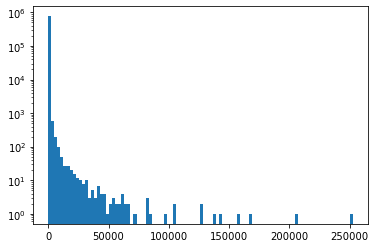

In [85]:
plt.hist(user_df.n_newly_exposed, log=True, bins=100)

In [100]:
formatted_columns = ['# Followers', '# Friends', '# Favorites', '# Newly Exposed', '# Tweets', 
                     '# Trends', 'In-Degree', 'Out-Degree', 'User Type']

user_df.columns = formatted_columns
user_df

,# Followers,# Friends,# Favorites,# Newly Exposed,# Tweets,# Trends,In-Degree,Out-Degree,User Type
author,,,,,,,,,
GunesliGuzel,1767.0,2161.0,127.0,1155.0,112,13,365.0,613.0,unexposed
yaprakergen,809.0,2573.0,708.0,0.0,157,8,NaN,NaN,astrobot
Erdemakkusss,1245.0,1310.0,32.0,385.0,17,2,263.0,311.0,exposed
iagdakzb,69.0,557.0,44.0,11.0,19,3,11.0,293.0,unexposed
EyiArif,49.0,88.0,0.0,0.0,1,1,NaN,NaN,unexposed
...,...,...,...,...,...,...,...,...,...
arif_tat,32.0,85.0,1.0,0.0,2,1,NaN,NaN,unexposed
btl4153551,10.0,277.0,0.0,0.0,24,1,0.0,89.0,unexposed
IslimTunc,7.0,20.0,3.0,0.0,3,1,0.0,10.0,unexposed


In [103]:
from tableone import TableOne
tab = TableOne(user_df.dropna(), groupby='User Type', nonnormal=user_df.columns.tolist(), categorical=[])
tab

Grouped by User Type                                                                                  
                                              Missing              Overall            astrobot              exposed           unexposed
n                                                                   329687               11541               244222               73924
# Followers, median [Q1,Q3]                         0   271.0 [95.0,851.0]  230.0 [61.0,750.0]  310.0 [113.0,993.0]  177.0 [56.0,505.0]
# Friends, median [Q1,Q3]                           0  301.0 [130.0,730.0]  248.0 [97.0,655.0]  363.0 [165.0,873.0]  162.0 [63.0,364.0]
# Favorites, median [Q1,Q3]                         0       5.0 [1.0,16.0]      8.0 [2.0,35.0]       5.0 [1.0,17.0]      4.0 [1.0,14.0]
# Newly Exposed, median [Q1,Q3]                     0        0.0 [0.0,5.0]      3.0 [0.0,24.0]        0.0 [0.0,2.0]      4.0 [0.0,17.0]
# Tweets, median [Q1,Q3]                            0        3.0 [2.0,5.0]      7.0 [3.0,17.0]        3.0 [2.0,5.0]       3.0 [2.0,6.0]
# Trends, median [Q1,Q3]                            0        2.0 [1.0,3.0]       2.0 [1.0,5.0]        2.0 [1.0,2.0]       2.0 [1.0,3.0]
In-Degree, median [Q1,Q3]                           0      20.0 [6.0,90.0]     18.0 [4.0,72.0]     27.0 [7.0,117.0]      9.0 [2.0,34.0]
Out-Degree, median [Q1,Q3]                          0    66.0 [24.0,179.0]   49.0 [16.0,148.0]    85.0 [33.0,220.0]     28.0 [9.0,73.0]

In [104]:
def split_column_name(x):
    if ',' in x:
        tok = x.split(',')
        new_str = '\\\\'.join(tok[:2])
        return '\\parbox{3cm}{' + new_str + '}'
    else:
        return x

def replace_substrings(text, replacements):
    for query, repl in replacements.items():
        new_text = text.replace(query, repl)
    return new_text
    
def reformat_tableone(tex):
    # function that takes a tex string and splits the std. errors or [q1,q3] onto a new line
    new_tex = ''
    new_lines = []
    n_lines = len(tex.split('\n'))
    for i, line in enumerate(tex.split('\n')):
        if i < 6 or n_lines-i <= 3:
            if i == 3:
                temp = [split_column_name(x) for x in line.split('&')]
                new_lines.append('&'.join(temp) + '\\\\')
            else:
                new_lines.append(line)
        else:
            mod_line, extra_line = [], []
            for word in line.split('&'):
                if '[' in word:
                    beg, end = word.index('['), word.index(']')
                    mod_line.append(word[:beg])
                    extra_line.append('('+ word[beg+1:end] + ')')
                else:
                    mod_line.append(word)
                    extra_line.append('{}')
            new_lines.append('&'.join(mod_line) + '\\\\')
            new_lines.append('&'.join(extra_line)+ '\\\\')
            
    return '\n'.join(new_lines)

In [105]:
replacements = {'\\multicolumn{4}{l}{Grouped by label}' : '\\multicolumn{4}{c}{Grouped by User Type} \\cr \\cline{2-7}'}


In [108]:
print(reformat_tableone(replace_substrings(
    tab.tableone.drop(columns=[('Grouped by User Type', 'Missing')]).to_latex(), replacements)))

\begin{tabular}{llllll}
\toprule
                           & {} & \multicolumn{4}{l}{Grouped by User Type} \\
                           & {} &              Overall &            astrobot &              exposed &           unexposed \\\\
\midrule
n & {} &               329687 &               11541 &               244222 &               73924 \\
\# Followers, median & {} &   271.0 &  230.0 &  310.0 &  177.0 \\
(Q1,Q3)&{}&(95.0,851.0)&(61.0,750.0)&(113.0,993.0)&(56.0,505.0)\\
\# Friends, median & {} &  301.0 &  248.0 &  363.0 &  162.0 \\
(Q1,Q3)&{}&(130.0,730.0)&(97.0,655.0)&(165.0,873.0)&(63.0,364.0)\\
\# Favorites, median & {} &       5.0 &      8.0 &       5.0 &      4.0 \\
(Q1,Q3)&{}&(1.0,16.0)&(2.0,35.0)&(1.0,17.0)&(1.0,14.0)\\
\# Newly Exposed, median & {} &        0.0 &      3.0 &        0.0 &      4.0 \\
(Q1,Q3)&{}&(0.0,5.0)&(0.0,24.0)&(0.0,2.0)&(0.0,17.0)\\
\# Tweets, median & {} &        3.0 &      7.0 &        3.0 &       3.0 \\
(Q1,Q3)&{}&(2.0,5.0)&(3.0,17.0)&(2.0,5.0)&(2.0,6